# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

In [13]:
pip install seebuoy

In [14]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)


## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [15]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [16]:
# read in file
# wave_df = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')

In [17]:
# num rows and columns
ny_buoy.shape

(6490, 14)

In [18]:
# num of categorical variables
cat_count = 0
for dtype in ny_buoy.dtypes:
    if dtype == 'object':
        cat_count = cat_count + 1

In [19]:
print('# of categorical variables:',cat_count)
print('# of continuous variables:',ny_buoy.shape[1] - cat_count - 1) # subtract and extra column as 1 column is an ID column

# of categorical variables: 0
# of continuous variables: 13


In [20]:
# How I identified a buoy to investigate
ny_buoys = wave_df[wave_df['closest_state'] == 'New York']
ny_buoys.head()
# use 44065 because it's off the coast and not in a lake or something

,station_id,owner,ttype,hull,name,payload,location,timezone,forecast,note,lat_lon,lat,lon,closest_city,closest_state,ownercode,ownername,countrycode
321,44022,Y,Moored Buoy,NaN,Execution Rocks,NaN,"40.883 N 73.728 W (40&#176;53'0"" N 73&#176;43'...",E,FZUS51.KOKX,NaN,40.883 N 73.728 W,40.883,-73.728,New Rochelle,New York,Y,MYSOUND,US
324,44025,N,3-meter foam buoy,3D57,"LONG ISLAND - 30 NM South of Islip, NY",SCOOP payload,"40.251 N 73.164 W (40&#176;15'3"" N 73&#176;9'5...",E,FZNT21.KWBC FZUS51.KOKX,The buoy from station 44025 has gone adrift as...,40.251 N 73.164 W,40.251,-73.164,Freeport,New York,N,NDBC,US
357,44065,N,3-meter foam buoy,3DV12,New York Harbor Entrance - 15 NM SE of Breezy ...,SCOOP payload,"40.369 N 73.703 W (40&#176;22'10"" N 73&#176;42...",E,FZUS51.KOKX FZUS51.KPHI,Right whales are active off NY from November t...,40.369 N 73.703 W,40.369,-73.703,Valley Stream,New York,N,NDBC,US
358,44066,N,3-meter foam buoy,3DV46,"Texas Tower #4 - 75 NM East of Long Beach, NJ",SCOOP payload,"39.618 N 72.644 W (39&#176;37'6"" N 72&#176;38'...",E,FZNT22.KWBC,</p>Right whales are active off NJ from Novemb...,39.618 N 72.644 W,39.618,-72.644,Freeport,New York,N,NDBC,US
361,44069,ST,Buoy,NaN,Great South Bay,NaN,"40.699 N 73.087 W (40&#176;41'55"" N 73&#176;5'...",E,FZUS51.KOKX,Buoy recovered 2/4/24.,40.699 N 73.087 W,40.699,-73.087,Freeport,New York,ST,Stony Brook University,US


### Creating a DF for ALL NY buoys


In [21]:
from seebuoy import NDBC
ndbc = NDBC()

df_buoys = ndbc.stations()
m = df_buoys["closest_state"] == "New York"
df_ny = df_buoys[m]

df_available = ndbc.available_data(dataset="all")

# subset down to ny stations
m = df_available["station_id"].isin(df_ny["station_id"])
df_ny_avail = df_available[m] # using the mask

piv_ny = pd.pivot_table(
    df_ny_avail, 
    index="station_id", 
    columns="dataset", 
    aggfunc=len, 
    values="file_name"
)

ny_station_ids = piv_ny.index.tolist()
print("Number of stations around NY: ", len(ny_station_ids))
print(ny_station_ids)

Number of stations around NY:  3
['44022', '44065', '44069']


In [22]:
# creating a df for the combined data for all buoys around NY
ny_buoys_standard = pd.DataFrame()

for station_id in ny_station_ids:

    # get the standard data for a singular buoy
    df_station = ndbc.get_data(station_id, dataset="standard")
    
    # Add a column for station ID
    df_station['station_id'] = station_id
    
    # Concatenate the current station's data to the combined DataFrame
    ny_buoys_standard = pd.concat([ny_buoys_standard, df_station], ignore_index=False)


print(ny_buoys_standard.shape)
print(ny_buoys_standard['station_id'].nunique())
ny_buoys_standard.head(2)

(12124, 15)
3


,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide,station_id
date,,,,,,,,,,,,,,,
2023-12-30 00:00:00,250.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,6.3,NaN,NaN,NaN,44022
2023-12-30 00:15:00,250.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,9.1,NaN,6.3,NaN,NaN,NaN,44022


### Handling missing data

In [23]:

nan_count = ny_buoy.isna().sum()
nan_count

wind_direction         6490
wind_speed               14
wind_gust                14
wave_height            3199
dominant_period        4344
average_period         3199
mean_wave_direction    3199
pressure                241
air_temp               6490
water_temp               48
dewpoint               6490
visibility             6490
pressure_tendency      5463
tide                   6490
dtype: int64

In [24]:
# missing data
# it appears there is a lot of missing data
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data



,Total NA,Total Rows,Percent
wind_direction,6490,6490,100.000000
air_temp,6490,6490,100.000000
dewpoint,6490,6490,100.000000
visibility,6490,6490,100.000000
tide,6490,6490,100.000000
pressure_tendency,5463,6490,84.175655
dominant_period,4344,6490,66.933744
wave_height,3199,6490,49.291217
average_period,3199,6490,49.291217
mean_wave_direction,3199,6490,49.291217


In [25]:
# dropping cols where there is 100% NA
ny_buoy.dropna(axis=1, how='all', inplace=True)

# dropping rows where average_period is null
ny_buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
ny_buoy.dropna(subset=['wave_height'], inplace=True)


In [26]:
# doing the same but for the multiple buoys
ny_buoys_standard.dropna(axis=1, how='all', inplace=True)

# dropping rows where average_period is null
ny_buoys_standard.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
ny_buoys_standard.dropna(subset=['wave_height'], inplace=True)

In [27]:
# missing data after dropping cols
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data

,Total NA,Total Rows,Percent
pressure_tendency,3286,3291,99.848070
dominant_period,1145,3291,34.791857
pressure,131,3291,3.980553
water_temp,21,3291,0.638104
wind_speed,13,3291,0.395017
wind_gust,13,3291,0.395017
wave_height,0,3291,0.000000
average_period,0,3291,0.000000
mean_wave_direction,0,3291,0.000000


In [28]:
ny_buoy

,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,water_temp,pressure_tendency
date,,,,,,,,,
2023-12-30 00:10:00,5.0,6.0,0.8,NaN,5.4,124.0,1004.2,9.6,NaN
2023-12-30 00:20:00,4.0,6.0,0.8,9.0,5.4,124.0,1004.1,9.6,NaN
2023-12-30 00:40:00,5.0,6.0,0.8,NaN,5.4,140.0,1004.1,9.5,NaN
2023-12-30 00:50:00,5.0,6.0,0.8,8.0,5.4,140.0,1004.1,9.5,NaN
2023-12-30 01:20:00,5.0,7.0,0.8,8.0,5.2,154.0,1003.7,9.5,NaN
...,...,...,...,...,...,...,...,...,...
2024-02-13 15:50:00,12.0,15.0,1.6,6.0,4.5,87.0,995.6,5.8,NaN
2024-02-13 16:10:00,12.0,15.0,1.7,NaN,4.6,87.0,995.9,5.8,NaN
2024-02-13 16:20:00,12.0,15.0,1.7,6.0,4.6,87.0,996.2,5.8,NaN


### Testing the validity of data acquisition

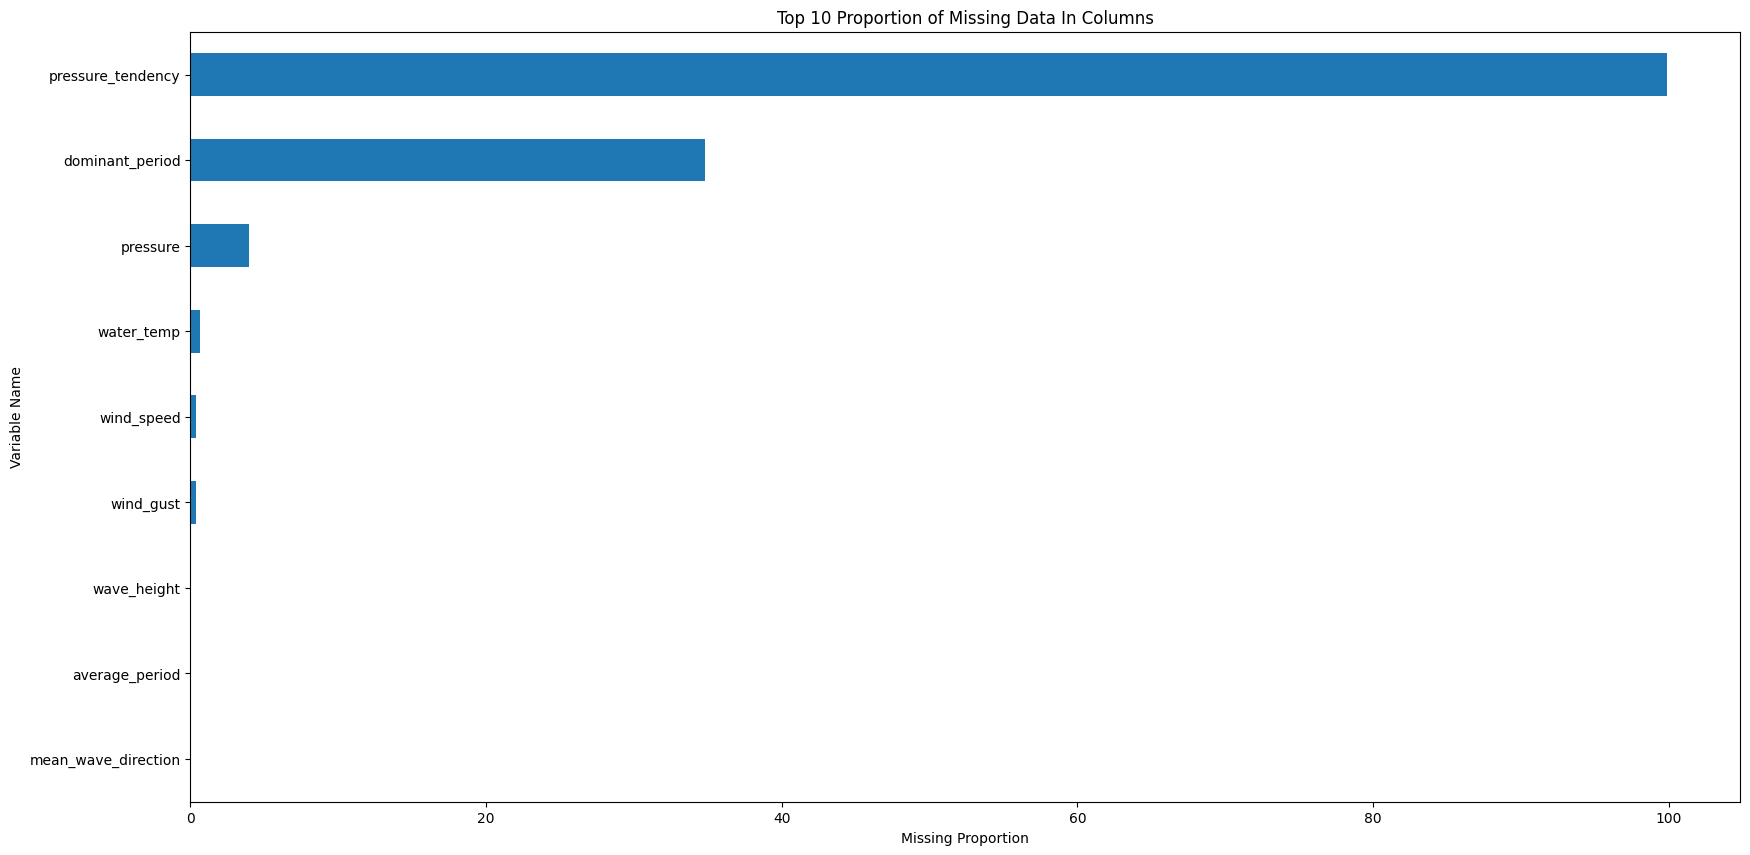

In [29]:
missing_data['Percent'].head(10).plot(kind='barh', figsize = (20,10)).invert_yaxis() # top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 10 Proportion of Missing Data In Columns")
plt.show()

## Handling missing data


In [30]:
from sklearn.impute import SimpleImputer

# Replace missing data with mode
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(ny_buoy)
ny_buoy_mode = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Replace missing data with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(ny_buoy)
ny_buoy_mean = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Interpolate missing values using spline interpolation
ny_buoy_interpolated = ny_buoy.interpolate(method='spline', order=2)



In [31]:
# doing the same for ny_buoys_standard

# Replace missing data with mode
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(ny_buoys_standard)
ny_buoy_mode_multiple = pd.DataFrame(imputer.transform(ny_buoys_standard), columns=ny_buoys_standard.columns)

# Replace missing data with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(ny_buoys_standard)
ny_buoy_mean_multiple = pd.DataFrame(imputer.transform(ny_buoys_standard), columns=ny_buoys_standard.columns)

# Interpolate missing values using spline interpolation
ny_buoy_interpolated_multiple = ny_buoys_standard.interpolate(method='spline', order=2)

ValueError: Shape of passed values is (3291, 10), indices imply (3291, 13)

In [ ]:
#Check remaining missing values if any 
all_data_na = (ny_buoy.isnull().sum() / len(ny_buoy)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
pressure_tendency,99.507541
dominant_period,33.394891
pressure,3.385657
wind_speed,2.523853
wind_gust,2.523853


### Handling Outliers

#### Target Variable

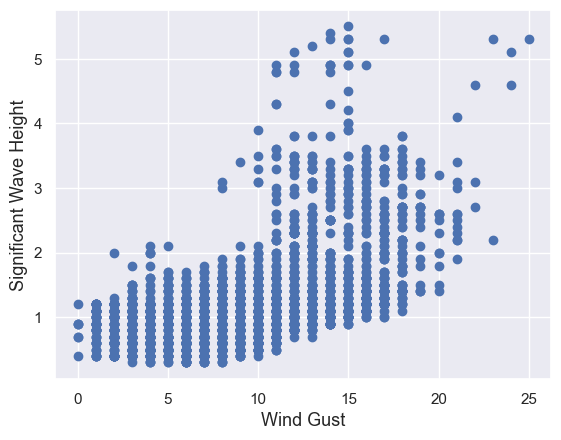

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['wind_gust'], y = ny_buoy['wave_height'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Wind Gust', fontsize=13)
plt.show()

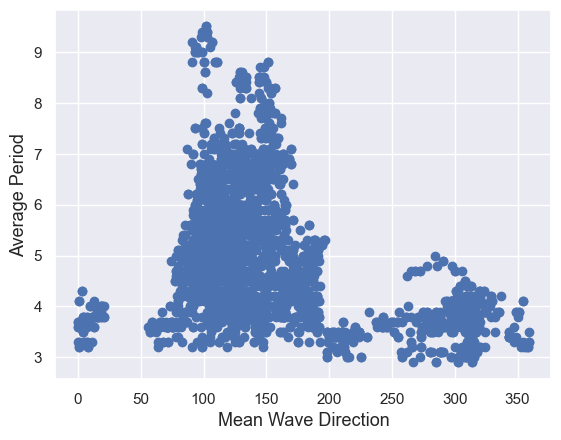

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['mean_wave_direction'], y = ny_buoy['average_period'],)
plt.ylabel('Average Period', fontsize=13)
plt.xlabel('Mean Wave Direction', fontsize=13)
plt.show()

In [ ]:
# Remove non finite values
ny_buoy = ny_buoy[np.isfinite(ny_buoy['wave_height'])]


 mu = 0.74 and sigma = 0.28



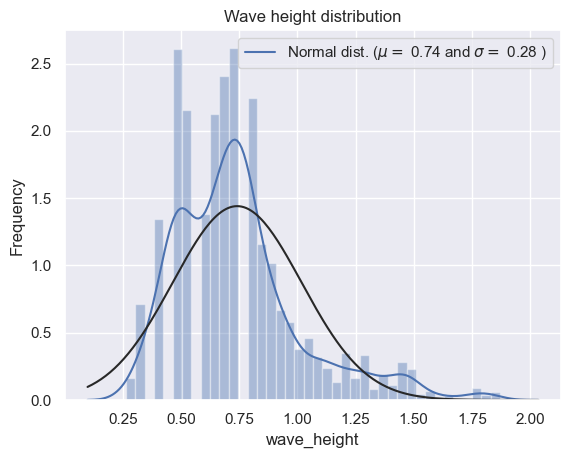

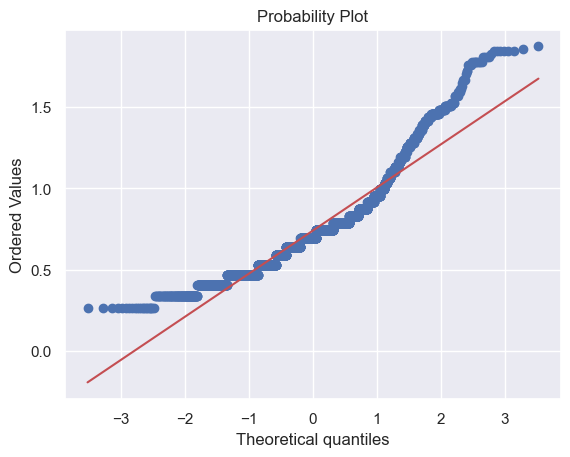

In [ ]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["wave_height"] = np.log1p(ny_buoy["wave_height"])

# Check the new distribution 
sns.distplot(ny_buoy['wave_height'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['wave_height'], plot=plt)
plt.show()


 mu = 1.76 and sigma = 0.20



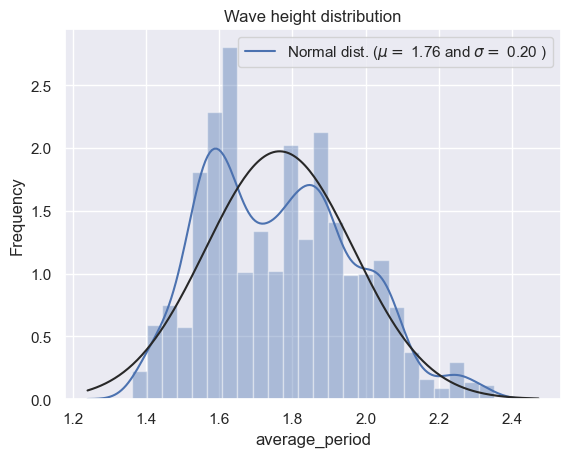

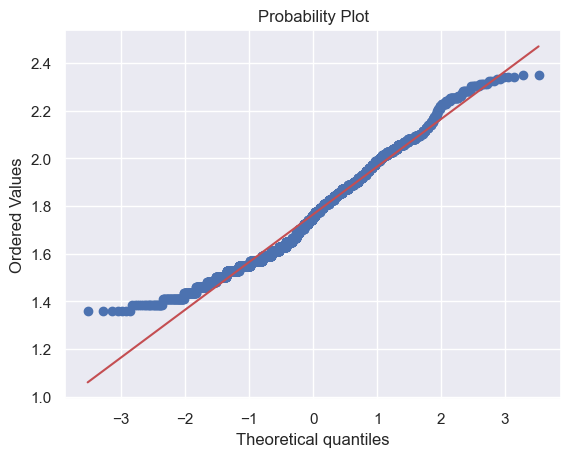

In [ ]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["average_period"] = np.log1p(ny_buoy["average_period"])

# Check the new distribution 
sns.distplot(ny_buoy['average_period'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['average_period'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['average_period'], plot=plt)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

In [ ]:
from sklearn.preprocessing import LabelEncoder

Target Variable Scatterplots

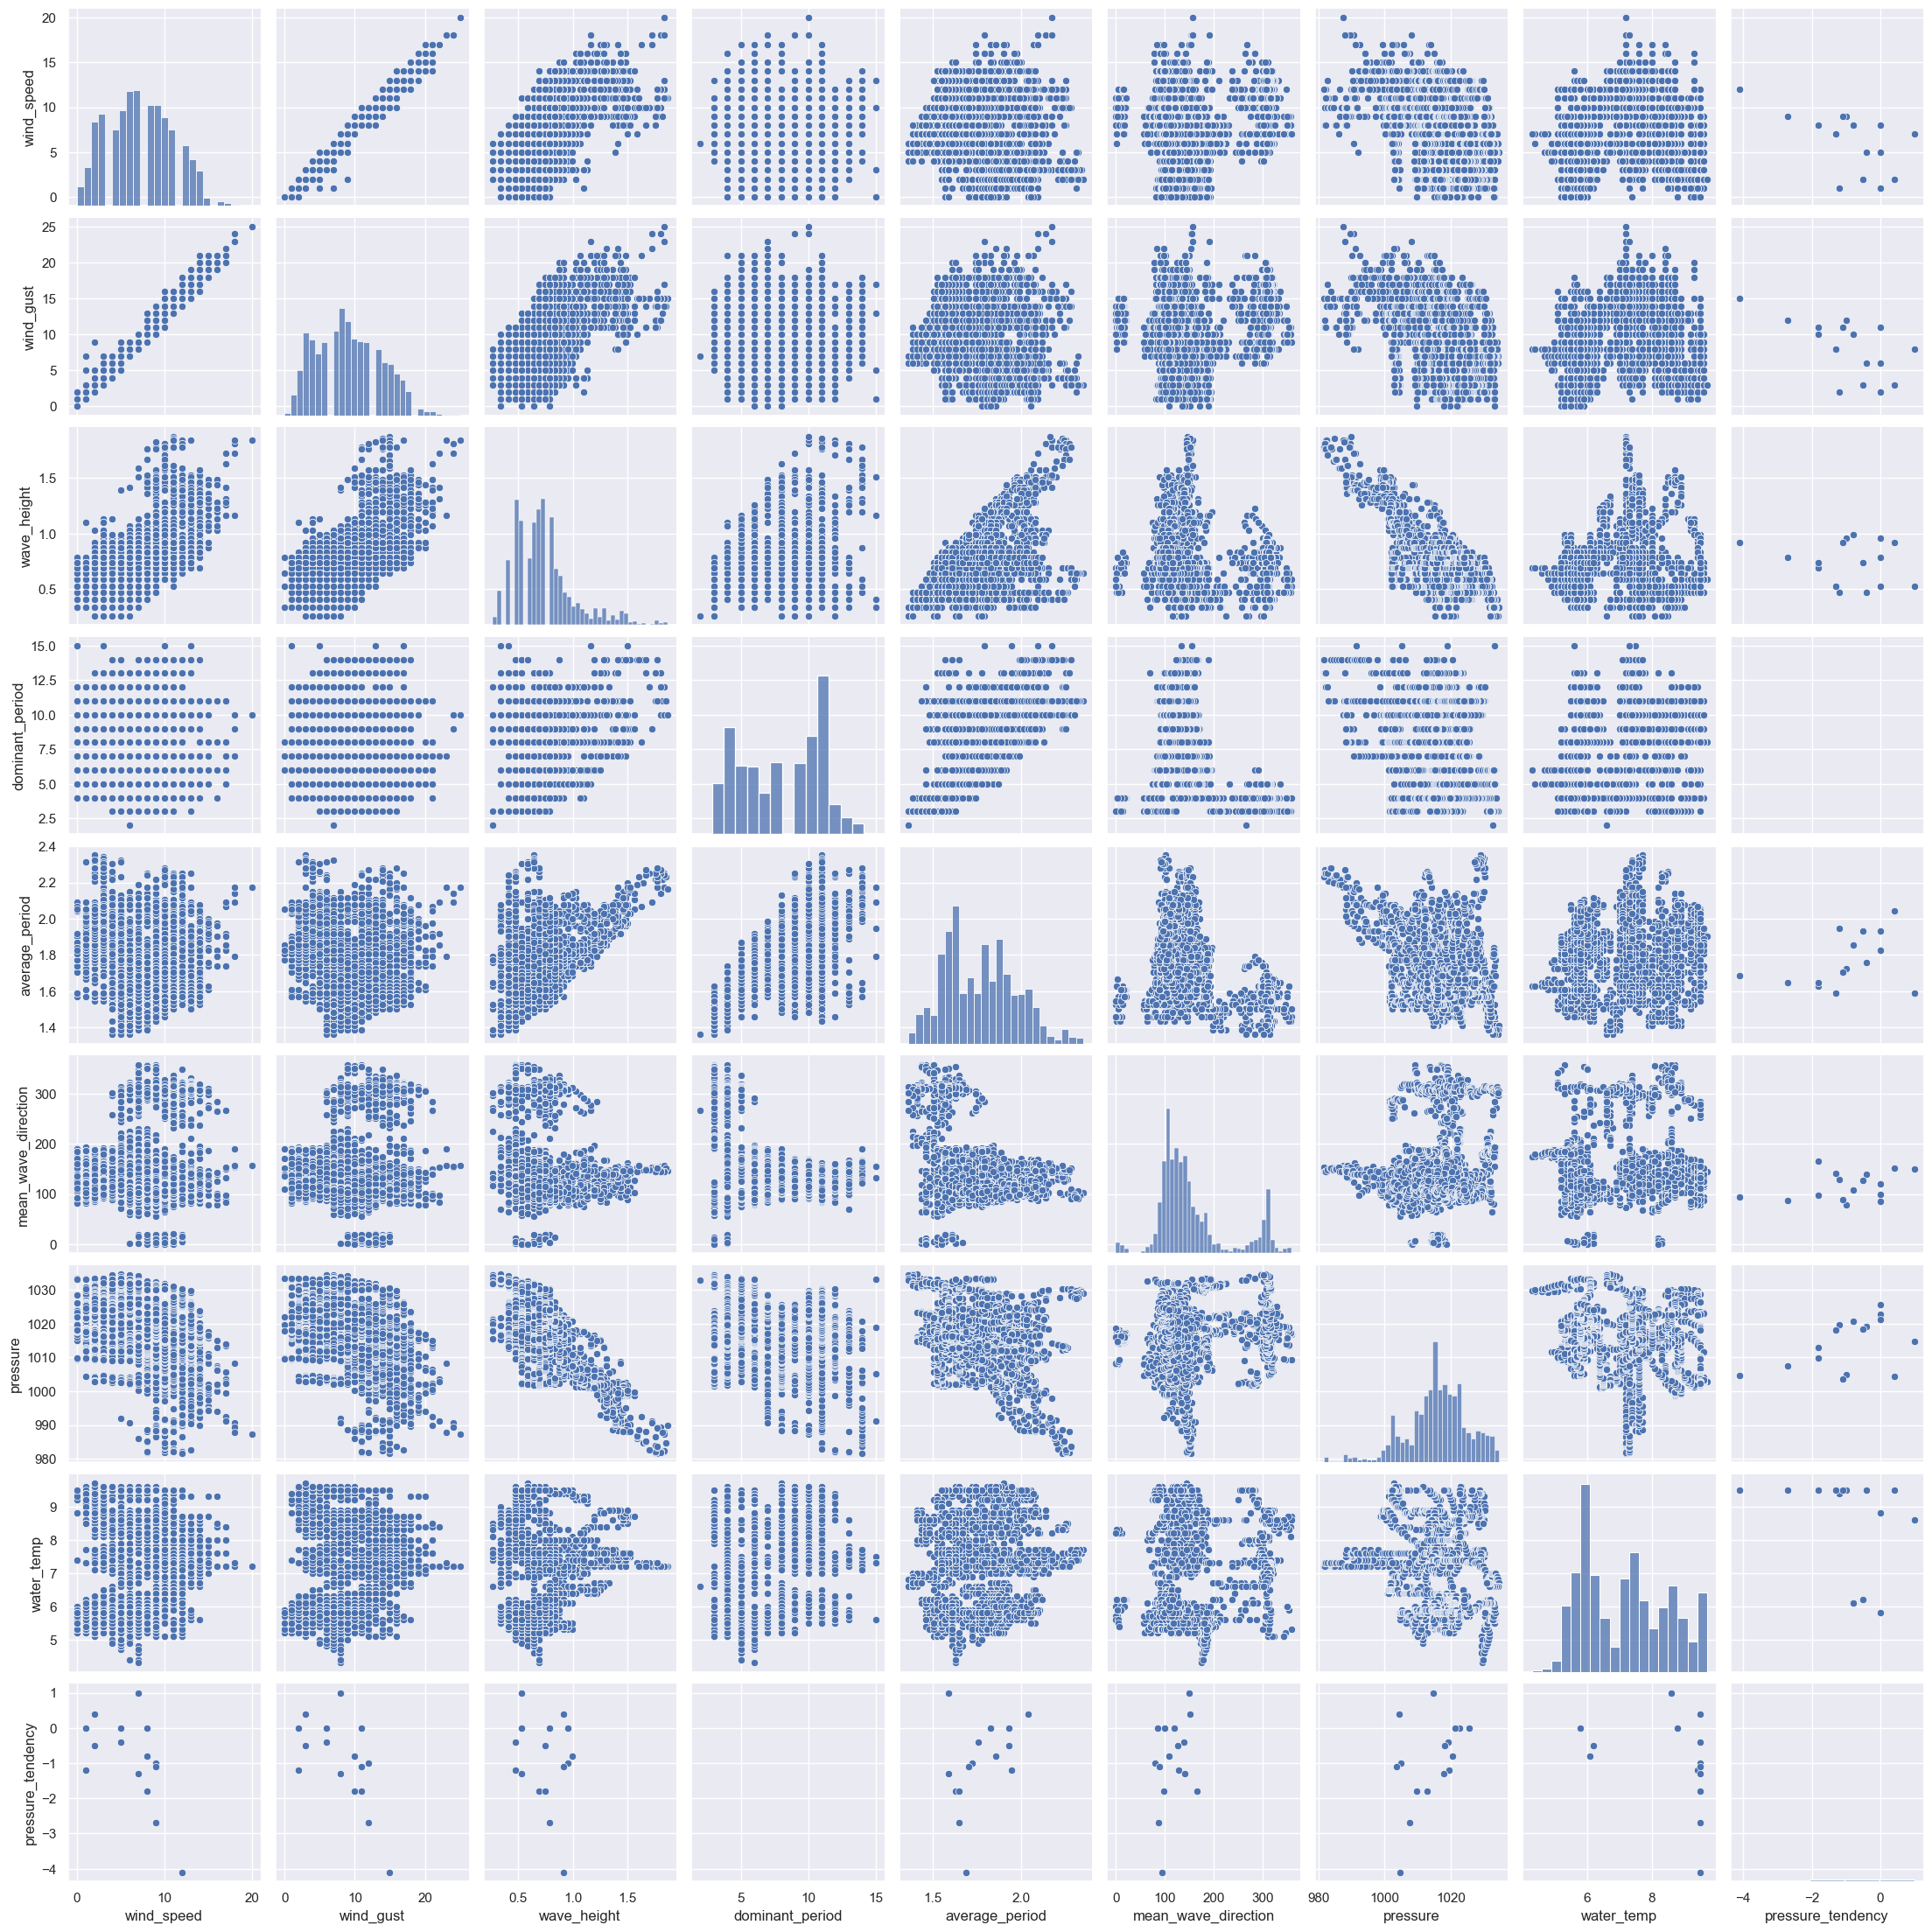

In [ ]:
# scatterplot
sns.set()
cols = ['wind_speed', 'wind_gust', 'wave_height', 
        'dominant_period', 'average_period', 'mean_wave_direction', 
        'pressure', 'water_temp',
        'pressure_tendency']
sns.pairplot(ny_buoy[cols], size = 2.5)
plt.show();

Correlation Matrix

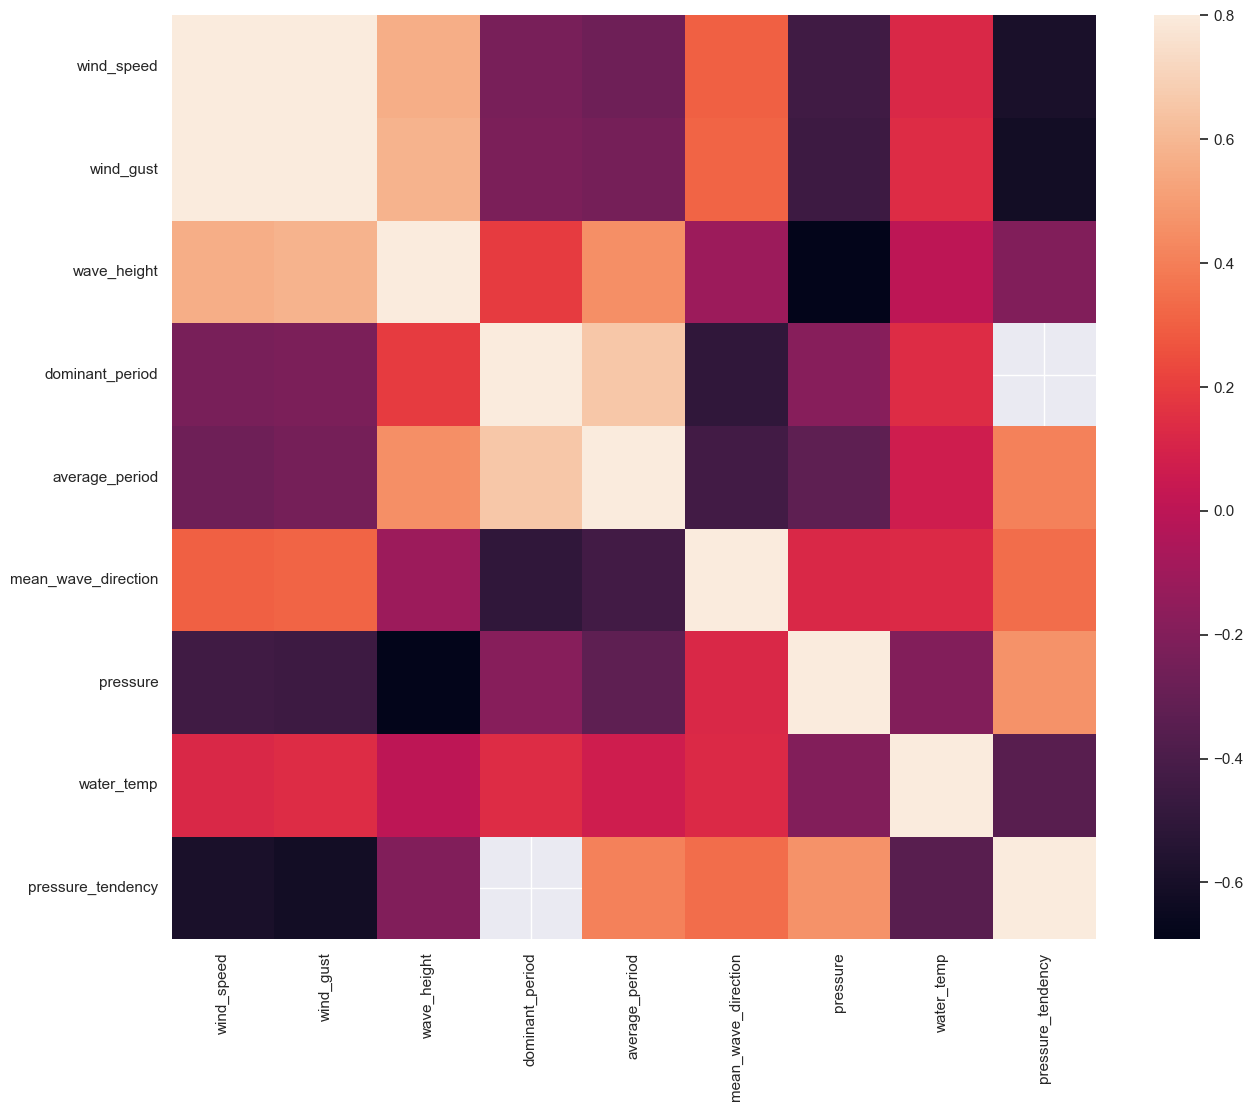

In [ ]:
# Correlation map to see how conditions are correlated with wave height and average period
corrmat = ny_buoy.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
# TODO: Here, we would change continuous variables to categorical variables if needed.
# For this example, we don't need to do this.

#### Label encode categorical variables

In [ ]:
# We only have one categorical variable, so we won't be doing this step at this point

## Data Analytics <a class="anchor" id="data-analytics"></a>

Added below to run code on codespaces that dont have things pre installed

In [ ]:
import sys

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 660.6 kB/s eta 0:02:31
   ---------------------------------------- 0.3/99.8 MB 3.2 MB/s eta 0:00:32
    --------------------------------------- 1.3/99.8 MB 9.2 MB/s eta 0:00:11
   - -------------------------------------- 2.7/99.8 MB 14.1 MB/s eta 0:00:07
   - -------------------------------------- 2.9/99.8 MB 12.4 MB/s eta 0:00:08
   - -------------------------------------- 2.9/99.8 MB 12.4 MB/s eta 0:00:08
   - -------------------------------------- 2.9/99.8 MB 12.4 MB/s eta 0:00:08
   - -------------------------------------- 4.0/99.8 MB 10.7 MB/s eta 0:00:09
   - -------------------------------------- 4.6/99.8 MB 11.0 MB/s eta 0:00:09
   - -------------------------------------- 4.9/99.8 MB 10.3 MB/s eta 0:00:10
   -- ------------------------------------- 5.3/99.8 MB 10.5 MB/s eta 0:00:09
   

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# return a list containing all the column names in wave_df except for 'Hs'.
# aka isolating our dependent variable: avg wave height. 
train_df = ny_buoy[ny_buoy.columns.difference(['wave_height', 'average_period'])]
train_df.head()

,dominant_period,mean_wave_direction,pressure,pressure_tendency,water_temp,wind_gust,wind_speed
date,,,,,,,
2023-12-25 00:10:00,NaN,122.0,1028.3,NaN,9.1,2.0,1.0
2023-12-25 00:20:00,6.0,122.0,1028.4,NaN,9.1,1.0,1.0
2023-12-25 00:50:00,7.0,129.0,1028.3,NaN,9.0,3.0,2.0
2023-12-25 01:10:00,NaN,130.0,1028.2,NaN,8.8,3.0,2.0
2023-12-25 01:20:00,6.0,130.0,1028.3,NaN,8.7,3.0,2.0


In [ ]:
# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [ ]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [ ]:
rf = RandomForestRegressor(n_estimators=100)

In [ ]:
dt = DecisionTreeRegressor(max_depth = 10)

In [ ]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [ ]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

#### Algorithm Results on a 5 Fold Cross Validation

In [ ]:
score_linear = rmse_cv(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_base.py", line 578, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1192, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1003, in check_array
    _assert_all_finite(
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
score_linear_no_int = rmse_cv(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1311 (0.0326)



In [ ]:
score_neigh = rmse_cv(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.1501 (0.0497)



In [ ]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1416 (0.0581)



In [ ]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1308 (0.0540)



In [ ]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1243 (0.0492)



In [ ]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1245 (0.0510)



In [ ]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

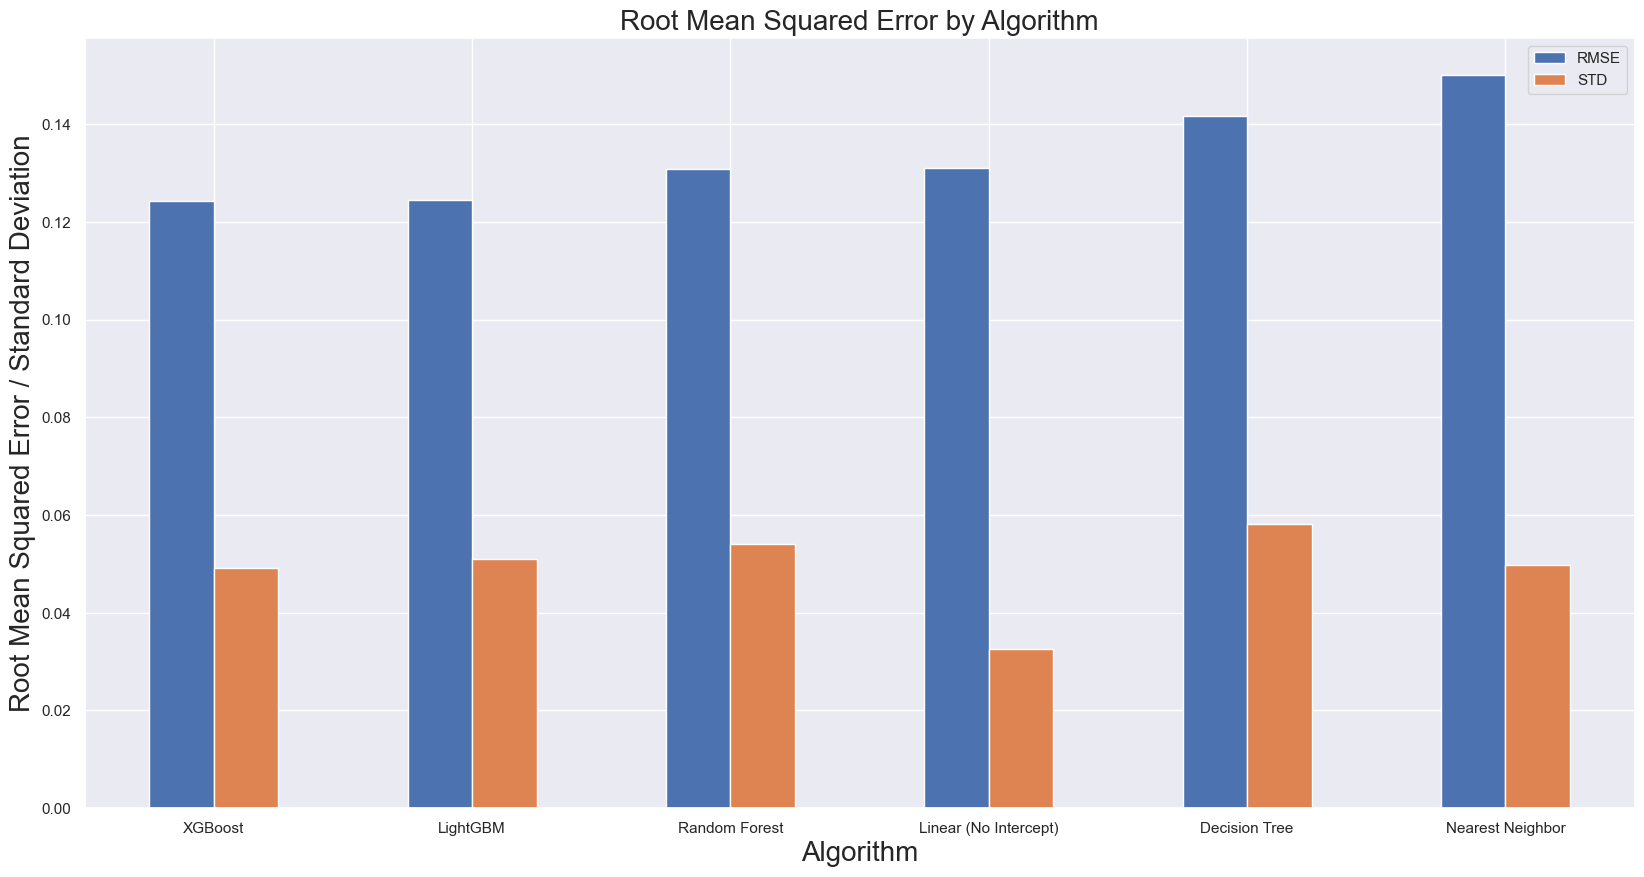

In [ ]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

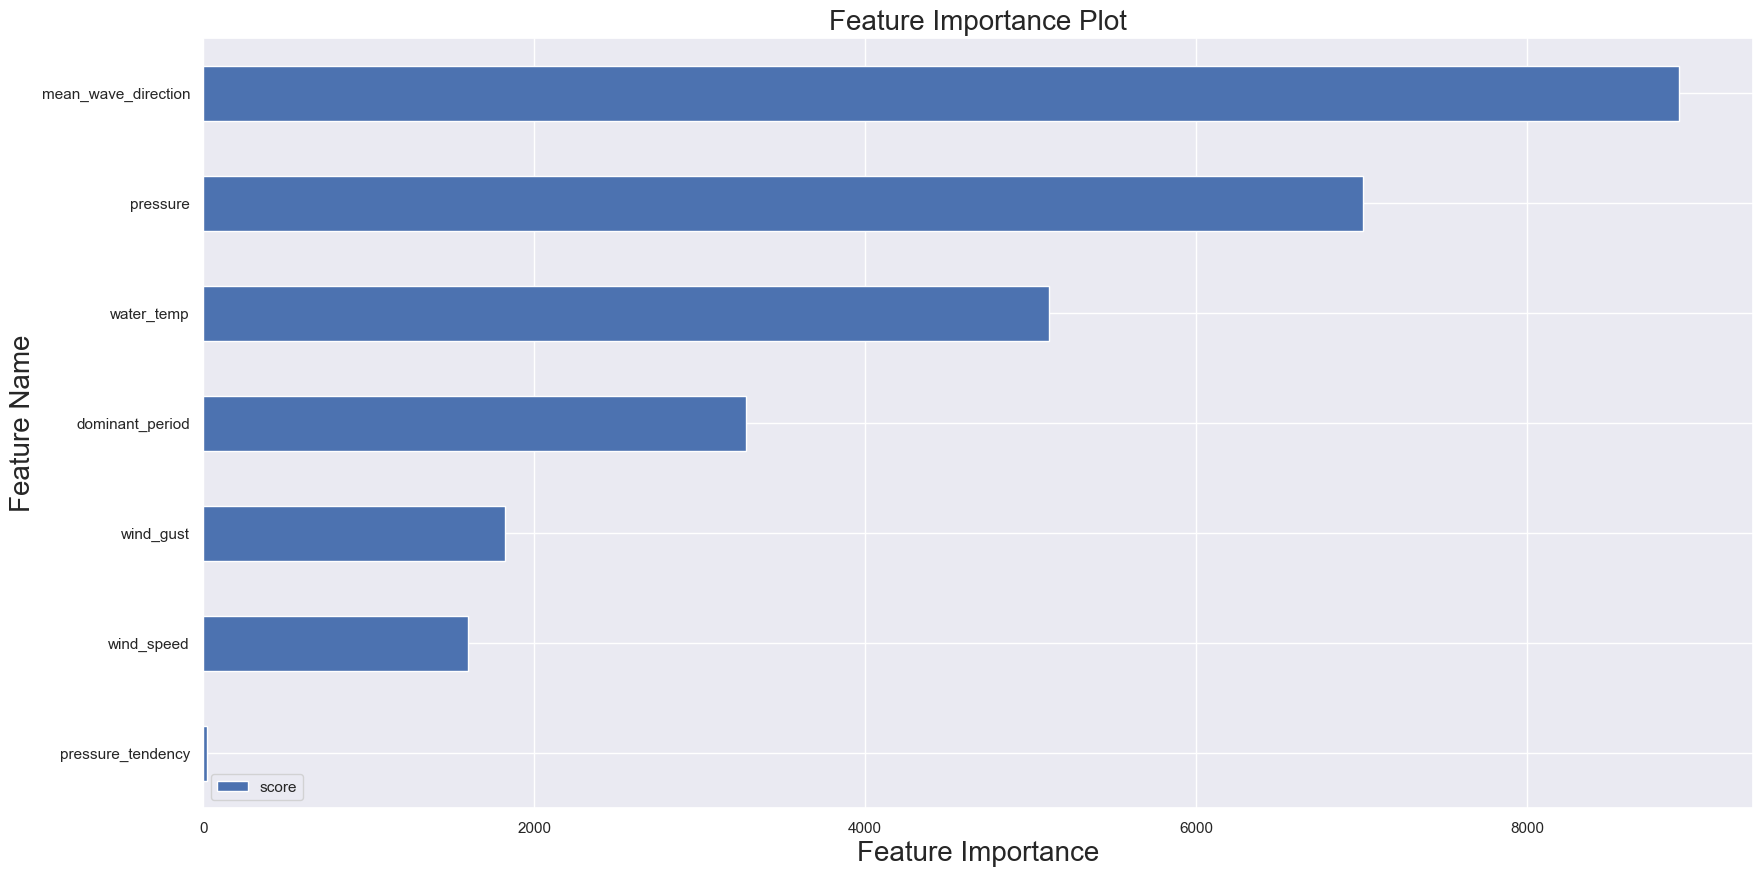

In [ ]:
model = model_xgb.fit(train_df, ny_buoy.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

## Repeat Training Models, but for Average Period

In [ ]:
# Validation function for wave height
n_folds = 5

def rmse_cv_period(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse_period = np.sqrt(-cross_val_score(model, train_df, ny_buoy.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse_period

In [ ]:
score_linear = rmse_cv_period(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.1451 (0.0302)



In [ ]:
score_linear_no_int = rmse_cv_period(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1441 (0.0263)



In [ ]:
score_neigh = rmse_cv_period(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.1296 (0.0238)



In [ ]:
score_dt = rmse_cv_period(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1338 (0.0201)



In [ ]:
score_rf = rmse_cv_period(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

NameError: name 'rmse_cv_period' is not defined

In [ ]:
score_xg = rmse_cv_period(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1045 (0.0105)



In [ ]:
score_lgbm = rmse_cv_period(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1035 (0.0093)



In [ ]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

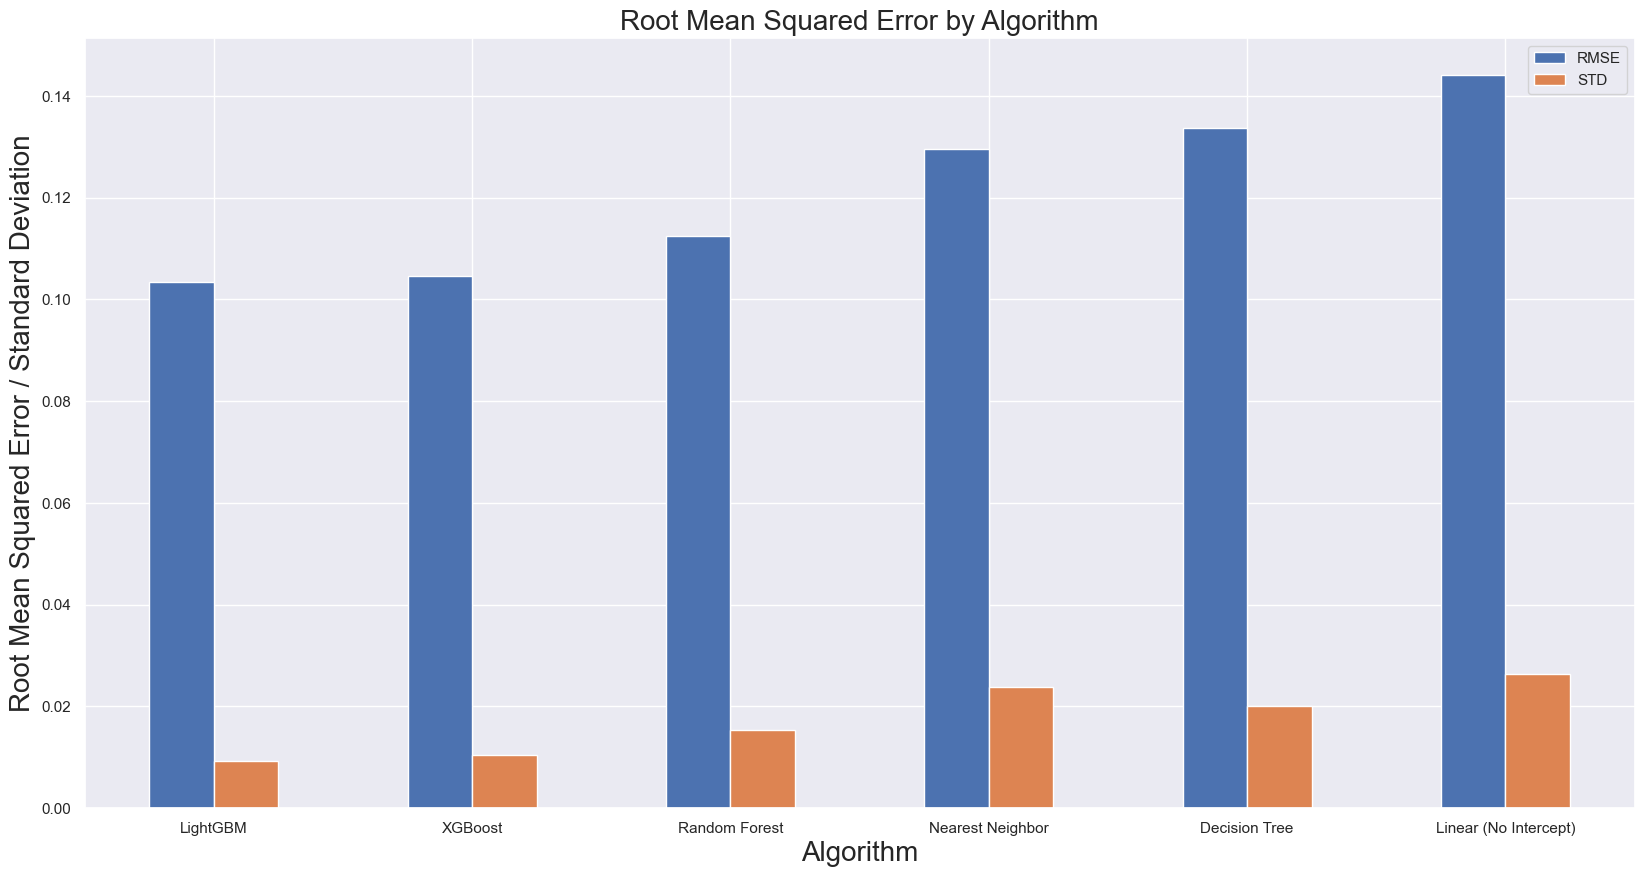

In [ ]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

<AxesSubplot:title={'center':'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

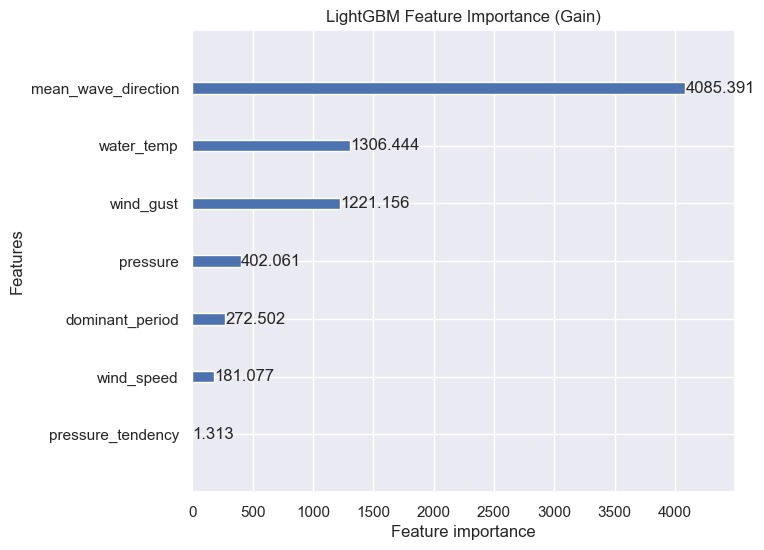

In [ ]:
model = model_lgb.fit(train_df, ny_buoy.average_period) #fit model on entire dataset to get variable importance since we fit it on each fold
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

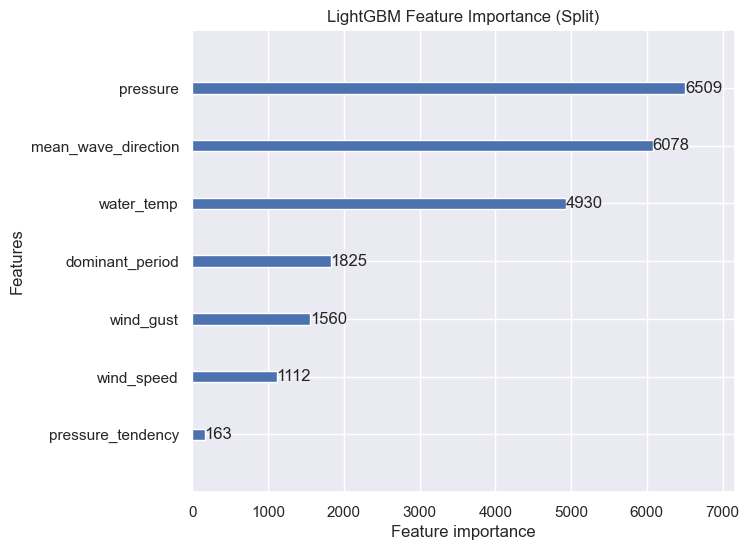

In [ ]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()